## Remove all files from folder

In [71]:
import os
import glob
ann_type = 'train'
file_list = [f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/occluded_masks/*',
             f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/segmentations/*',
             f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/visible_masks/*',
             f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/visualize_occlusion_masks/*',
             f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/visualize_visible_masks/*']

for delete_files_in_folder_path in file_list:
    files = glob.glob(delete_files_in_folder_path)
    for f in files:
        os.remove(f)

In [91]:
import json
import os
from tqdm import tqdm
final_json_path = '/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json'
import numpy as np
import glob

def find_num_cc_dataset(final_json_path):
    f = open(final_json_path)
    data = json.load(f)
    f.close()

    num_connected_component_list = []
    size_of_connected_component_list = []
    amodal_area = 0
    occ_area = 0
    ooc_instances = 0
    occlusion_rate_list = []
    # query_img_id = [49,53]
    import pycocotools.mask as mask_util

    curr_anno = []
    cur_img_id = data["annotations"][0]["image_id"]

    for i in tqdm(range(len(data["annotations"]))):
        ann = data["annotations"][i]

        if i == len(data["annotations"]) - 1:
            curr_anno.append(ann)
            img_info = data["images"][i]

            # print(curr_anno)
            inst_vis_mask_list = []
            occlusion_mask_list = []
            for image_anno in curr_anno:
                segm = image_anno["visible_mask"]
                visible_mask = mask_util.decode(segm)
                inst_vis_mask_list.append(visible_mask)

                segm = image_anno["occluded_mask"]
                occ_mask = mask_util.decode(segm)
                occlusion_mask_list.append(occ_mask)

            gt_ooam = generate_ooam(inst_vis_mask_list,occlusion_mask_list)

            """ === Generate Directed Graph === """
            # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
            # f, (ax1,ax2) = plt.subplots(1,2)
            # show_graph_with_labels(overlap_adjacency_matrix,ax1)
            labels = [i for i in range(1,len(gt_ooam)+1)]
            labels_dict = {}
            for i in range(len(gt_ooam)):
                labels_dict.update({i:labels[i]})
            
            rows, cols = np.where(gt_ooam == 1)
            rows += 1
            cols += 1
            edges = zip(rows.tolist(), cols.tolist())
            nodes_list = [i for i in range(1, len(gt_ooam)+1)]
            # Initialise directed graph G
            G = nx.DiGraph()
            G.add_nodes_from(nodes_list)
            G.add_edges_from(edges)
            
            # pos=nx.spring_layout(G,k=1/sqrt(N))
            # pos=nx.planar_layout(G)

            # print("Nodes:",G.nodes())
            # print("Edges:",G.edges())
            # print(G.in_edges())
            # print(G.out_edges())
            # get start nodes
            start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
            # print("start_nodes:",start_nodes)
            # get end nodes
            end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
            for node in end_nodes:
                if node in start_nodes:
                    end_nodes.remove(node)
            # print("end_nodes:",end_nodes)
            # get intermediate notes
            intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
            # print("intermediate_nodes:",intermediate_nodes)

            # print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
            # largest_wcc = max(nx.weakly_connected_components(G), key=len)
            # largest_wcc_size = len(largest_wcc)
            # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
            
            wcc_list = list(nx.weakly_connected_components(G))
            # scc_list = list(nx.strongly_connected_components(G))
            # cc_list = list(nx.connected_components(G))
            # wcc_len = []
            # for component in wcc_list:
                # wcc_len.append(len(component))

            # print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)

            for component in wcc_list:
                size_of_connected_component_list.append(len(component))
            # for component in scc_list:
            #     num_components += len(component)

            num_connected_component_list.append(len(wcc_list))

        elif ann["image_id"] == cur_img_id:
            curr_anno.append(ann)
            img_info = data["images"][i]

            inst_vis_mask_list = []
            occlusion_mask_list = []
            for image_anno in curr_anno:
                segm = image_anno["visible_mask"]
                visible_mask = mask_util.decode(segm)
                inst_vis_mask_list.append(visible_mask)

                segm = image_anno["occluded_mask"]
                occ_mask = mask_util.decode(segm)
                occlusion_mask_list.append(occ_mask)

            gt_ooam = generate_ooam(inst_vis_mask_list,occlusion_mask_list)

            """ === Generate Directed Graph === """
            # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
            # f, (ax1,ax2) = plt.subplots(1,2)
            # show_graph_with_labels(overlap_adjacency_matrix,ax1)
            labels = [i for i in range(1,len(gt_ooam)+1)]
            labels_dict = {}
            for i in range(len(gt_ooam)):
                labels_dict.update({i:labels[i]})
            
            rows, cols = np.where(gt_ooam == 1)
            rows += 1
            cols += 1
            edges = zip(rows.tolist(), cols.tolist())
            nodes_list = [i for i in range(1, len(gt_ooam)+1)]
            # Initialise directed graph G
            G = nx.DiGraph()
            G.add_nodes_from(nodes_list)
            G.add_edges_from(edges)
            
            # pos=nx.spring_layout(G,k=1/sqrt(N))
            # pos=nx.planar_layout(G)

            # print("Nodes:",G.nodes())
            # print("Edges:",G.edges())
            # print(G.in_edges())
            # print(G.out_edges())
            # get start nodes
            start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
            # print("start_nodes:",start_nodes)
            # get end nodes
            end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
            for node in end_nodes:
                if node in start_nodes:
                    end_nodes.remove(node)
            # print("end_nodes:",end_nodes)
            # get intermediate notes
            intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
            # print("intermediate_nodes:",intermediate_nodes)

            # print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
            # largest_wcc = max(nx.weakly_connected_components(G), key=len)
            # largest_wcc_size = len(largest_wcc)
            # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
            
            wcc_list = list(nx.weakly_connected_components(G))
            # scc_list = list(nx.strongly_connected_components(G))
            # cc_list = list(nx.connected_components(G))
            # wcc_len = []
            # for component in wcc_list:
                # wcc_len.append(len(component))

            # print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)
            for component in wcc_list:
                size_of_connected_component_list.append(len(component))
            # for component in scc_list:
            #     num_components += len(component)

            num_connected_component_list.append(len(wcc_list))


            continue
        # image_id = ann["image_id"]
        # if image_id < query_img_id[0]:
        #     continue

        # if image_id > query_img_id[1]:
        #     break
        
        # ann_id = ann["id"]
        # print(image_id)
        segm = ann["visible_mask"]
        visible_mask = mask_util.decode(segm)

        segm = ann["occluded_mask"]
        occ_mask = mask_util.decode(segm)

        # amodal_area += np.count_nonzero(amodal_mask)
        # occ_area += np.count_nonzero(occ_mask)
        # occlusion_rate = np.count_nonzero(occ_mask)/np.count_nonzero(amodal_mask)
        # occlusion_rate_list.append(occlusion_rate)
        

        curr_anno = []
        curr_anno.append(ann)
        cur_img_id = ann["image_id"]

    # occlusion_rate = occ_area/amodal_area


    
        
        

    # return  amodal_area, occ_area, occlusion_rate, ooc_instances
    return num_connected_component_list, size_of_connected_component_list

100%|██████████| 31198/31198 [13:11<00:00, 39.42it/s] 


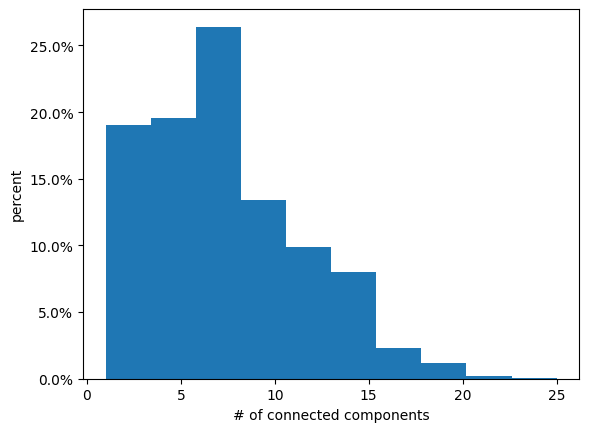

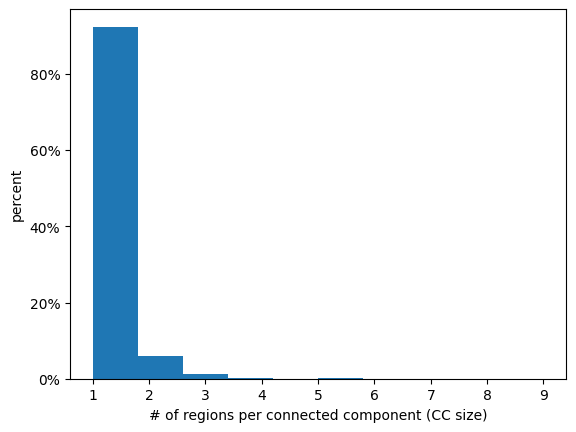

In [92]:
final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val_tabletop.json'
num_connected_component_list, size_of_connected_component_list = find_num_cc_dataset(final_json_path)
plot_histogram_num_cc(num_connected_component_list)

plot_histogram_size_cc(size_of_connected_component_list)

100%|██████████| 325687/325687 [3:06:34<00:00, 29.09it/s]  


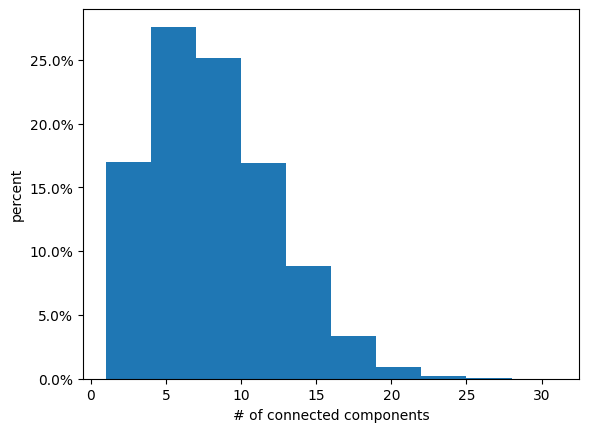

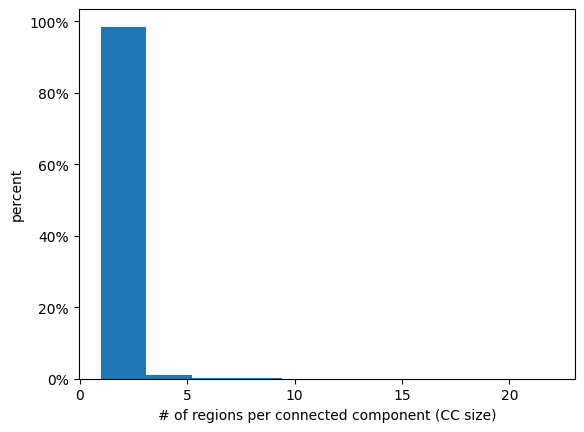

In [93]:
final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train_tabletop.json'
num_connected_component_list, size_of_connected_component_list = find_num_cc_dataset(final_json_path)
plot_histogram_num_cc(num_connected_component_list)

plot_histogram_size_cc(size_of_connected_component_list)

In [ ]:
final_json_path = '/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json'
num_connected_component_list, size_of_connected_component_list = find_num_cc_dataset(final_json_path)
plot_histogram_num_cc(num_connected_component_list)

plot_histogram_size_cc(size_of_connected_component_list)

In [ ]:
final_json_path = '/home/ngzhili/uoais/datasets/syntable/validation/uoais_val.json'
num_connected_component_list, size_of_connected_component_list = find_num_cc_dataset(final_json_path)
plot_histogram_num_cc(num_connected_component_list)

plot_histogram_size_cc(size_of_connected_component_list)

In [88]:
import os
import cv2
import glob
import numpy as np
import imageio
import torch

from tqdm import tqdm

from detectron2.engine import DefaultPredictor
from adet.config import get_cfg
from adet.utils.post_process import detector_postprocess, DefaultPredictor

from utils import normalize_depth, inpaint_depth, standardize_image, array_to_tensor
from foreground_segmentation.model import Context_Guided_Network
from termcolor import colored
import matplotlib.pyplot as plt
import networkx as nx

dataset_path = "/home/ngzhili/uoais/datasets/OSD-0.2-depth"
# load dataset
rgb_paths = sorted(glob.glob("{}/image_color/*.png".format(dataset_path)))
depth_paths = sorted(glob.glob("{}/disparity/*.png".format(dataset_path)))
vis_anno_paths = sorted(glob.glob("{}/annotation/*.png".format(dataset_path)))

amodal_anno_paths = sorted(glob.glob("{}/amodal_annotation/*.png".format(dataset_path)))
occlusion_anno_paths = sorted(glob.glob("{}/occlusion_annotation/*.png".format(dataset_path)))
# rgb_paths = rgb_paths[:40]
# depth_paths = depth_paths[:40]
# vis_anno_paths = vis_anno_paths[:40]

assert len(rgb_paths) == len(depth_paths)
assert len(rgb_paths) == len(vis_anno_paths)
assert len(amodal_anno_paths) != 0
assert len(occlusion_anno_paths) != 0
print(colored("Evaluation on OSD dataset: {} rgbs, {} depths, {} amodal masks, {} occlusion masks".format(
            len(rgb_paths), len(depth_paths), len(amodal_anno_paths), len(occlusion_anno_paths)), "green"))

def compute_occluded_masks(mask1, mask2):
    """Computes occlusions between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    # intersections and union
    mask1_area = np.count_nonzero(mask1)
    mask2_area = np.count_nonzero(mask2)
    intersection_mask = np.logical_and(mask1, mask2)
    intersection = np.count_nonzero(np.logical_and(mask1, mask2))

    iou = intersection/(mask1_area+mask2_area-intersection)

    return iou, intersection_mask.astype(float)

# A(i,j), col j, row i. row i --> col j
def generate_ooam(inst_vis_mask_list,occlusion_mask_list):
    rows = cols = len(inst_vis_mask_list)
    ooam = np.zeros((rows,cols))
    for i in range(0,len(inst_vis_mask_list)):
        visible_mask_i = inst_vis_mask_list[i] # occluder
        for j in range(0,len(occlusion_mask_list)):
            if j != i:
                occluded_mask_j = occlusion_mask_list[j] # occludee
                iou, _ = compute_occluded_masks(visible_mask_i,occluded_mask_j) 
                
                if iou > 0.1: # object i's visible mask is overlapping object j's occluded mask
                    # print(iou)
                    # print(np.count_nonzero(_))
                    ooam[i][j] = 1
    return ooam
    
metrics_all = [] # amodal mask evaluation
num_inst_all_pred = 0 # number of all pred instances
num_inst_all_gt = 0 # number of all GT instances
num_inst_occ_pred = 0 # number of occluded prediction
num_inst_occ_mat = 0 # number of occluded and matched
num_inst_mat = 0 # number of matched instance

mask_ious, occ_ious = 0, 0
pre_occ, rec_occ, f_occ = 0, 0, 0
pre_bou, rec_bou, f_bou = 0, 0, 0
num_correct = 0 # for occlusion classification
num_occ_over75 = 0 # number of instance IoU>0.75
occ_over_75_rate = 0 # rate of instance IoU>0.75

num_correct_occ_ooam = 0 # total correct occlusion prediction
num_all_occ_ooam = 0 # total occlusion combinations

# for i, (rgb_path, depth_path) in enumerate(zip(tqdm(rgb_paths), depth_paths)):
BACKGROUND_LABEL = 0
BG_LABELS = {}
BG_LABELS["floor"] = [0, 1]
BG_LABELS["table"] = [0, 1, 2]
W, H = 640, 480

num_connected_component_list = []
size_of_connected_component_list = []
occlusion_rate_list = []
for i, (rgb_path, depth_path, anno_path) in enumerate(zip(tqdm(rgb_paths), depth_paths, vis_anno_paths)):
    # print(rgb_path)
    # load rgb and depth
    rgb_img = cv2.imread(rgb_path)
    rgb_img = cv2.resize(rgb_img, (W, H))
    depth_img = imageio.imread(depth_path)
    depth_img = normalize_depth(depth_img)
    depth_img = cv2.resize(depth_img, (W, H), interpolation=cv2.INTER_NEAREST)
    depth_img = inpaint_depth(depth_img)
    
    
    # load GT (visible masks)
    vis_anno = imageio.imread(anno_path)
    vis_anno = cv2.resize(vis_anno, (W, H), interpolation=cv2.INTER_NEAREST)
    labels_anno = np.unique(vis_anno)
    labels_anno = labels_anno[~np.isin(labels_anno, [BACKGROUND_LABEL])]
    labels_anno = sorted(labels_anno)
    # print(labels_anno)

    inst_vis_mask_list = []
    for label in labels_anno:
        vis_mask = vis_anno.copy()
        vis_mask[np.where(vis_mask == label)] = 1
        vis_mask =vis_mask.astype(np.uint8)
        inst_vis_mask_list.append(vis_mask)

    # load GT (amodal masks)
    img_name = os.path.basename(rgb_path)[:-4]
    annos = [] # [instance, IMG_H, IMG_W]
    amodal_mask_list = []
    occlusion_mask_list = []
    filtered_amodal_paths = list(filter(lambda p: img_name + "_" in p, amodal_anno_paths))
    filtered_occlusion_paths = list(filter(lambda p: img_name + "_" in p, occlusion_anno_paths))
    # print(filtered_occlusion_paths)
    for anno_path in filtered_amodal_paths:
        # get instance id  
        # print(anno_path)
        inst_id = os.path.basename(anno_path)[:-4].split("_")[-1]
        inst_id = int(inst_id)
        # load mask image
        anno = imageio.imread(anno_path)
        anno = cv2.resize(anno, (W, H), interpolation=cv2.INTER_NEAREST)
        # fill mask with instance id
        cnd = anno > 0
        anno_mask = np.zeros((H, W))
        anno_mask[cnd] = inst_id
        annos.append(anno_mask)
        amodal_mask_list.append(anno_mask)  

        # print(os.path.basename(anno_path))
        occ_dir = glob.glob(f"{dataset_path}/occlusion_annotation/")[0]
        # print(occ_dir)

        occ_path = os.path.join(occ_dir,str(os.path.basename(anno_path)))
        # print(occ_path)
        if os.path.exists(occ_path):
            occ = imageio.imread(occ_path)
            occ = cv2.resize(occ, (W, H), interpolation=cv2.INTER_NEAREST)
            occ = occ[:,:] > 0

            idx = int(os.path.basename(occ_path)[:-4].split("_")[1]) - 1
        else:
            occ =np.zeros((H,W), np.uint8)
        # print("idx:",idx)
        # print(np.unique(occ))
        occlusion_mask_list.append(occ)

        occlusion_rate = np.count_nonzero(occ)/np.count_nonzero(anno_mask)
        occlusion_rate_list.append(occlusion_rate)
    
    # count occluded area of ground truth
    # all_occ_gt, all_bou_gt = 0, 0
    # occ_paths = filtered_occlusion_paths
    # for occ_path in occ_paths:
    #     occ = imageio.imread(occ_path)
    #     occ = cv2.resize(occ, (W, H), interpolation=cv2.INTER_NEAREST)
    #     occ = occ[:,:] > 0

    #     idx = int(os.path.basename(occ_path)[:-4].split("_")[1]) - 1
    #     # print("idx:",idx)
    #     # print(np.unique(occ))
    #     occlusion_mask_list.append(occ)
    # generate occlusion ordering (gt_ooam)
    # print(inst_vis_mask_list)
    # print(occlusion_mask_list)

    # print(len(occlusion_mask_list),len(amodal_mask_list))
    
    gt_ooam = generate_ooam(inst_vis_mask_list,occlusion_mask_list)


    """ === Generate Directed Graph === """
    # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
    # f, (ax1,ax2) = plt.subplots(1,2)
    # show_graph_with_labels(overlap_adjacency_matrix,ax1)
    labels = [i for i in range(1,len(gt_ooam)+1)]
    labels_dict = {}
    for i in range(len(gt_ooam)):
        labels_dict.update({i:labels[i]})
    
    rows, cols = np.where(gt_ooam == 1)
    rows += 1
    cols += 1
    edges = zip(rows.tolist(), cols.tolist())
    nodes_list = [i for i in range(1, len(gt_ooam)+1)]
    # Initialise directed graph G
    G = nx.DiGraph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges)
    
    # pos=nx.spring_layout(G,k=1/sqrt(N))
    # pos=nx.planar_layout(G)

    # print("Nodes:",G.nodes())
    # print("Edges:",G.edges())
    # print(G.in_edges())
    # print(G.out_edges())
    # get start nodes
    start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
    # print("start_nodes:",start_nodes)
    # get end nodes
    end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
    for node in end_nodes:
        if node in start_nodes:
            end_nodes.remove(node)
    # print("end_nodes:",end_nodes)
    # get intermediate notes
    intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
    # print("intermediate_nodes:",intermediate_nodes)

    # print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
    # largest_wcc = max(nx.weakly_connected_components(G), key=len)
    # largest_wcc_size = len(largest_wcc)
    # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
    
    wcc_list = list(nx.weakly_connected_components(G))
    # scc_list = list(nx.strongly_connected_components(G))
    # cc_list = list(nx.connected_components(G))
    # wcc_len = []
    # for component in wcc_list:
        # wcc_len.append(len(component))

    # print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)
    num_components = 0
    for component in wcc_list:
        size_of_connected_component_list.append(len(component))
    # for component in scc_list:
    #     num_components += len(component)

    num_connected_component_list.append(len(wcc_list))
    # if not nx.is_directed_acyclic_graph(G): #not G.is_directed():
    #     print("Graph is not directed and contains a cycle!")
    # else:
    #     dag_longest_path_length = nx.dag_longest_path_length(G)
    #     print("(Minimum no. of depth layers to order all regions in WCC) Longest directed path of Weakly Connected Components:",dag_longest_path_length)

    # nx.draw(gr, node_size=500, with_labels=True)
    # node_color_list = []
    # node_size_list = []
    # for node in nodes_list:
    #     if node in start_nodes:
    #         node_color_list.append('green')
    #         node_size_list.append(500)
    #     elif node in end_nodes:
    #         node_color_list.append('yellow')
    #         node_size_list.append(300)
    #     else:
    #         node_color_list.append('#1f78b4')
    #         node_size_list.append(300)

    # options = {
    # 'node_color': node_color_list,
    # 'node_size': node_size_list,
    # 'width': 1,
    # 'arrowstyle': '-|>',
    # 'arrowsize': 10
    # }
    # fig1 = plt.figure(figsize=(20, 6), dpi=80)
    
    # plt.subplot(1,3,1)
    # nx.draw_planar(G,  with_labels = True, arrows=True, **options)

    # dag = nx.is_directed_acyclic_graph(G)
    # print(f"Is Directed Acyclic Graph (DAG)?: {dag}")
    # if dag:
    #     title='Acyclic'
    # else:
    #     title='Cyclic'
    
    # import matplotlib.patches as mpatches
    # import matplotlib.pyplot as plt
    # colors = ["green", "#1f78b4", "yellow"]
    # texts = ["Top Layer", "Intermediate Layers", "Bottom Layer"]
    # patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
    #             label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    # plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.05), 
    #         loc='center', ncol=3, fancybox=True, shadow=True, 
    #         facecolor="w", numpoints=1, fontsize=10)
    # plt.title(f"Object Index: Directed Occlusion Order Graph ({title})")

print(occlusion_rate_list)

Evaluation on OSD dataset: 111 rgbs, 111 depths, 472 amodal masks, 237 occlusion masks


  0%|          | 0/111 [00:00<?, ?it/s]/tmp/ipykernel_5741/436066165.py:103: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  depth_img = imageio.imread(depth_path)
/tmp/ipykernel_5741/436066165.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  vis_anno = imageio.imread(anno_path)
/tmp/ipykernel_5741/436066165.py:138: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  anno = imageio.imr

[0.6359747762049653, 0.0, 0.31220147633521494, 0.0, 0.06257905197855809, 0.0, 0.3454167285693062, 0.0, 0.19510328997704668, 0.0, 0.15582614056720098, 0.3048677308364826, 0.0, 0.5053279659010183, 0.5146390711761737, 0.0, 0.5064540151421124, 0.21198698871894248, 0.0, 0.4228273317215931, 0.2535829189821585, 0.0, 0.5279139648900838, 0.0, 0.6129632583612484, 0.0, 0.5048085646888042, 0.0, 0.38453494451867776, 0.0, 0.23212425847937326, 0.0, 0.6035625517812759, 0.36849719344945314, 0.0, 0.6266162093976664, 0.4215585034553976, 0.0, 0.5137717566840122, 0.4019729958646804, 0.0, 0.7626971912273951, 0.03319443463521435, 0.0, 0.6154252788497119, 0.0, 0.5009534186870063, 0.0, 0.7089298646314969, 0.0, 0.37577452017530605, 0.0, 0.2814594759293114, 0.0, 0.28187190929924016, 0.0, 0.34986159585991095, 0.0, 0.41096433289299866, 0.0, 0.39124920735573876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02166104277783825, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1963142

In [57]:
len(connected_component_list)

111

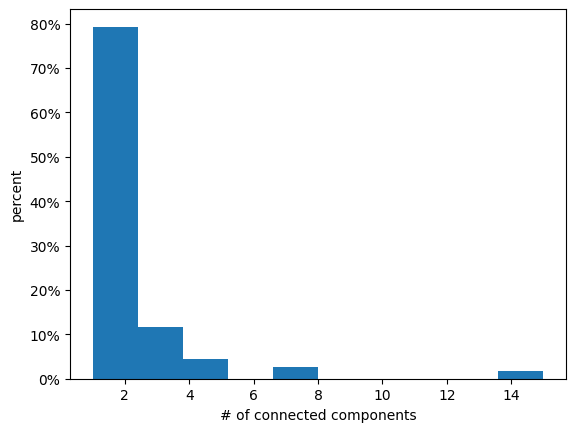

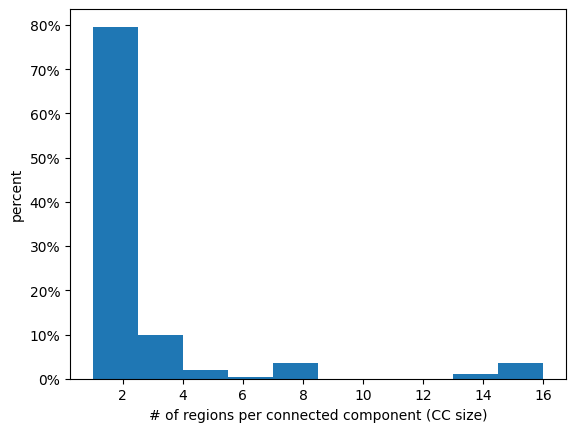

In [90]:
def plot_histogram_size_cc(data):
    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    bins = 10
    plt.hist(data, weights=np.ones(len(data)) / len(data),rwidth=1, bins=bins,align='mid')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.hist(data,bins=bins,align='mid')

    plt.xlabel("# of regions per connected component (CC size)")
    plt.ylabel("percent")

    plt.show()

def plot_histogram_num_cc(data):
    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    bins = 10
    plt.hist(data, weights=np.ones(len(data)) / len(data),rwidth=1, bins=bins,align='mid')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.hist(data,bins=bins,align='mid')

    plt.xlabel("# of connected components")
    plt.ylabel("percent")

    plt.show()

plot_histogram_num_cc(data=num_connected_component_list)

plot_histogram_size_cc(data=size_of_connected_component_list)

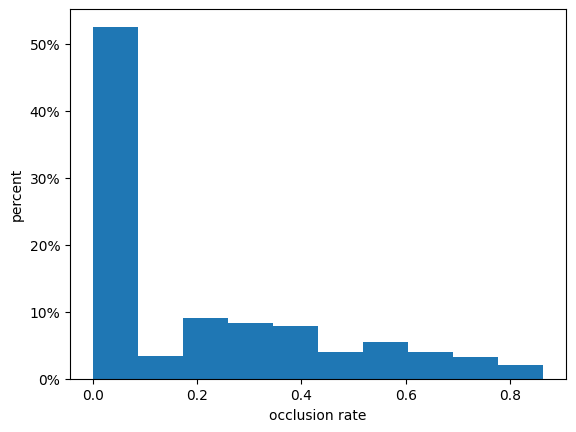

In [51]:
plot_histogram(occlusion_rate_list)

In [ ]:
import json
import os
from tqdm import tqdm
final_json_path = '/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json'
import numpy as np
import glob

def find_num_cc(final_json_path):
    f = open(final_json_path)
    data = json.load(f)
    f.close()

    occlusion_rate_list = []
    # query_img_id = [49,53]
    import pycocotools.mask as mask_util
    for i in tqdm(range(len(data["annotations"]))):
        ann = data["annotations"][i]
        # image_id = ann["image_id"]
        # if image_id < query_img_id[0]:
        #     continue

        # if image_id > query_img_id[1]:
        #     break
        
        # ann_id = ann["id"]
        # print(image_id)
        segm = ann["segmentation"]
        amodal_mask = mask_util.decode(segm)

        segm = ann["occluded_mask"]
        occ_mask = mask_util.decode(segm)

        # amodal_area += np.count_nonzero(amodal_mask)
        # occ_area += np.count_nonzero(occ_mask)
        occlusion_rate = np.count_nonzero(occ_mask)/np.count_nonzero(amodal_mask)
        occlusion_rate_list.append(occlusion_rate)
        # if np.count_nonzero(occ_mask) > 0:
        #     ooc_instances += 1

    # occlusion_rate = occ_area/amodal_area

    # return  amodal_area, occ_area, occlusion_rate, ooc_instances
    return occlusion_rate_list

In [2]:
# final_json_path= '/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json'
# final_json_path = '/home/ngzhili/uoais/datasets/syntable/validation/uoais_val.json'
# final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train.json'
# final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val.json'
final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val_tabletop.json'
f = open(final_json_path)
data = json.load(f)
f.close()
len(data["annotations"])

31198

100%|██████████| 31198/31198 [00:17<00:00, 1831.13it/s]


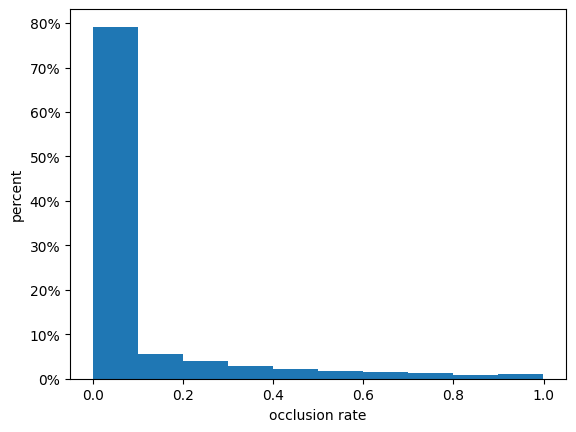

In [31]:
occlusion_rate_list = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val_tabletop.json')
len(occlusion_rate_list)
plot_histogram(occlusion_rate_list)

100%|██████████| 325687/325687 [02:56<00:00, 1847.38it/s]


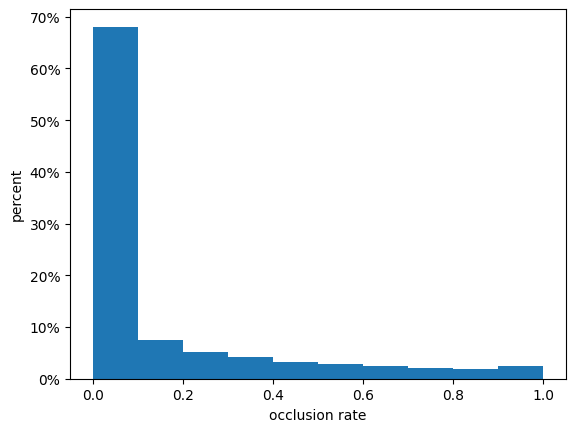

In [32]:
occlusion_rate_list = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train_tabletop.json')
len(occlusion_rate_list)
plot_histogram(occlusion_rate_list)

100%|██████████| 654837/654837 [05:48<00:00, 1879.21it/s]


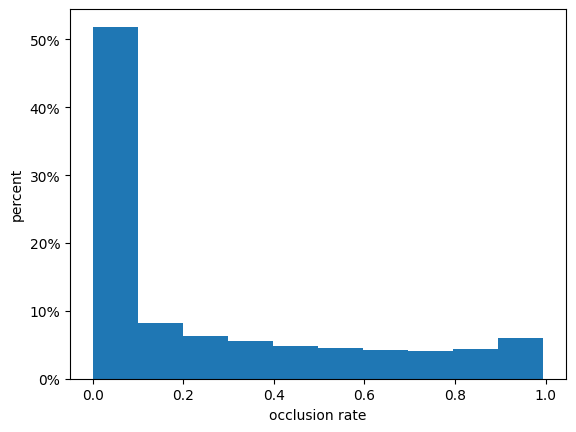

In [34]:
occlusion_rate_list = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json')
len(occlusion_rate_list)
plot_histogram(occlusion_rate_list)

100%|██████████| 89617/89617 [00:48<00:00, 1852.29it/s]


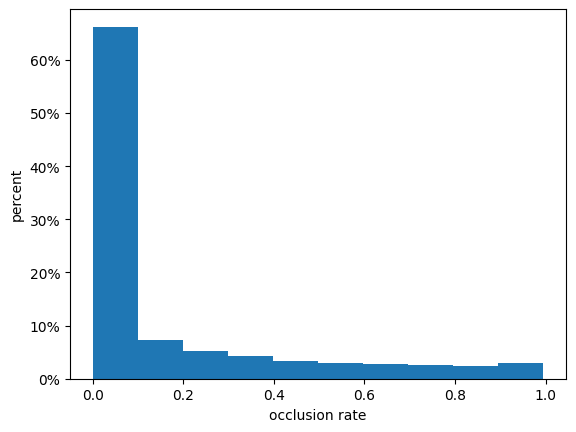

In [33]:
occlusion_rate_list = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/syntable/validation/uoais_val.json')
len(occlusion_rate_list)
plot_histogram(occlusion_rate_list)

In [30]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
# Plot seaborn histogram overlaid with KDE
# ax = sns.histplot(data=occlusion_rate_list, bins=20, stat='density', alpha= 1, kde=True,
#                   edgecolor='white', linewidth=0.5,
#                   line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
# ax.get_lines()[0].set_color('black') # edit line color due to bug in sns v 0.11.0

# # Edit legemd and add title
# ax.legend(frameon=False)
# ax.set_title('Seaborn histogram overlaid with KDE', fontsize=14, pad=15)

# plt.show()
# import matplotlib.pyplot as plt
# num_bins = 50
# plt.hist(occlusion_rate_list, bins=num_bins)
import numpy as np

def plot_histogram(data):
    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    # data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]
    data = occlusion_rate_list
    bins = 10
    plt.hist(data, weights=np.ones(len(data)) / len(data),rwidth=1, bins=bins,align='mid')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


    plt.xlabel("occlusion rate")
    plt.ylabel("percent")

    plt.show()

In [3]:
train_amodal_area, train_occ_area, occ_rate, ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json')
occ_rate, ooc_instances

100%|██████████| 654837/654837 [06:13<00:00, 1754.35it/s]


(0.17862584868968046, 437431)

In [4]:
val_amodal_area, val_occ_area, occ_rate, val_ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/syntable/validation/uoais_val.json')
occ_rate, ooc_instances

100%|██████████| 89617/89617 [00:50<00:00, 1768.26it/s]


(0.1162918038270751, 437431)

In [7]:
train_amodal_area

3684639182

In [8]:
val_amodal_area

189557555

In [6]:
total_amodal_area = train_amodal_area + val_amodal_area
total_occ_area = train_occ_area + val_occ_area

occlusion_rate = total_occ_area/total_amodal_area
occlusion_rate

0.1755759547530691

In [6]:
train_amodal_area, train_occ_area, occ_rate, train_ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train_tabletop.json')


100%|██████████| 325687/325687 [03:03<00:00, 1771.46it/s]


In [7]:
val_amodal_area, val_occ_area, occ_rate, val_ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val_tabletop.json')
occ_rate, val_ooc_instances

100%|██████████| 31198/31198 [00:18<00:00, 1726.64it/s]


(0.06586129939612646, 7680)

In [8]:
total_amodal_area = train_amodal_area + val_amodal_area
total_occ_area = train_occ_area + val_occ_area

occlusion_rate = total_occ_area/total_amodal_area
occlusion_rate

0.11159997492747474

In [9]:
train_ooc_instances+ val_ooc_instances

127129

In [10]:
final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train_tabletop.json'
f = open(final_json_path)
data = json.load(f)
f.close()
len(data["annotations"])

325687

In [11]:
final_json_path = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val_tabletop.json'
f = open(final_json_path)
data = json.load(f)
f.close()
len(data["annotations"])

31198

In [12]:
325687+31198

356885

In [8]:
amodal_area, occ_area, occ_rate, ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train.json')
occ_rate, ooc_instances

100%|██████████| 743044/743044 [07:07<00:00, 1738.87it/s]


(0.10854583990615357, 258926)

In [9]:
amodal_area, occ_area, occ_rate, ooc_instances = find_occlusion_rate_dataset('/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val.json')
occ_rate, ooc_instances

100%|██████████| 77714/77714 [00:45<00:00, 1726.30it/s]


(0.06894288605042385, 20242)

In [18]:
from os import listdir
from os.path import isfile, join
amodalpath = '/home/ngzhili/uoais/datasets/OSD-0.2-depth/amodal_annotation'
amodalfiles = [f for f in listdir(amodalpath) if isfile(join(amodalpath, f))]
occpath = '/home/ngzhili/uoais/datasets/OSD-0.2-depth/occlusion_annotation'
occfiles = [f for f in listdir(occpath) if isfile(join(occpath, f))]

from PIL import Image
import os
import numpy as np
count = 0
amodal_area = 0
occ_area = 0
for i in amodalfiles:
    i = os.path.join(amodalpath,i)
    im = Image.open(i)
    im = np.array(im)
    # count+=len(np.unique(im)) - 1

    amodal_area += np.count_nonzero(im)

for i in occfiles:
    i = os.path.join(occpath,i)
    im = Image.open(i)
    im = np.array(im)    
    occ_area += np.count_nonzero(im)
occ_area / amodal_area

0.24111107539485566

In [ ]:
from os import listdir
from os.path import isfile, join
amodalpath = '/home/ngzhili/uoais/datasets/OSD-0.2-depth/amodal_annotation'
amodalfiles = [f for f in listdir(amodalpath) if isfile(join(amodalpath, f))]

In [37]:
import glob
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders
dirname ='/home/ngzhili/uoais/datasets/OCID-dataset'
subfolders = fast_scandir(dirname)

folders = []
for i in subfolders:
    if 'label' in i :
        folders.append(i)
folders

['/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/curved/seq25/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/curved/seq26/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/curved/seq36/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/curved/seq35/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/mixed/seq21/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/mixed/seq32/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/mixed/seq31/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/mixed/seq22/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/cuboid/seq24/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/cuboid/seq23/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/cuboid/seq33/label',
 '/home/ngzhili/uoais/datasets/OCID-dataset/YCB10/table/bottom/cuboid/seq34/labe

In [41]:
count = 0
for folder in folders:
    amodalfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
    amodalpath = folder
    for i in amodalfiles:
        i = os.path.join(amodalpath,i)
        im = Image.open(i)
        im = np.array(im)
        count+=len(np.unique(im)) - 2
count

19097

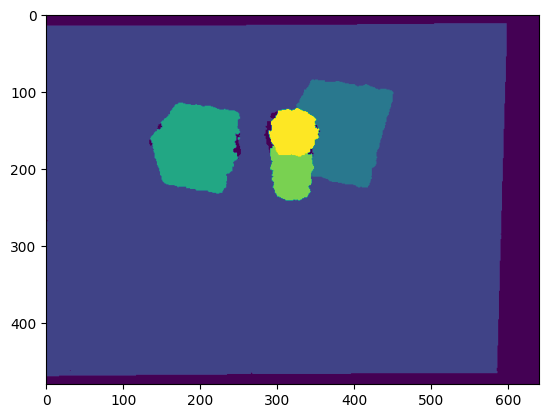

In [24]:
i = '/home/ngzhili/uoais/datasets/OCID-dataset/ARID10/floor/bottom/mixed/seq31/label/result_2018-08-23-14-49-03.png'
im = Image.open(i)
im = np.array(im)
plt.imshow(im)

In [25]:
np.unique(im)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [16]:
len(onlyfiles)

237

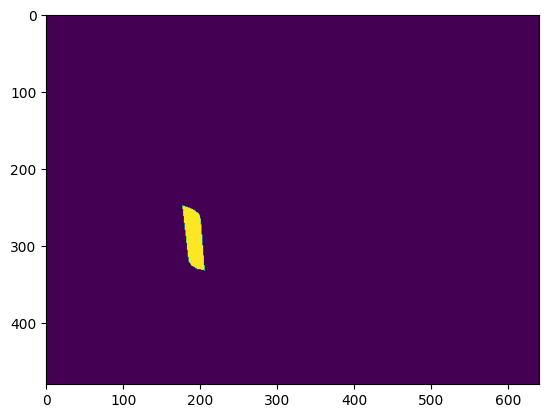

In [15]:
import matplotlib.pyplot as plt
plt.imshow(im)

array([0, 1, 2], dtype=uint8)

## Reduce dataset

In [16]:
import json
import os
output_dir = "/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/"
output_dir = "/home/ngzhili/uoais/datasets/syntable/train/"
output_dir = "/home/ngzhili/uoais/datasets/syntable/validation/"
# output_dir = "/home/zhili/Documents/uoais/datasets/syntable/validation"
# concatenate all coco.json checkpoint files to final coco.json


# concatenate all coco.json checkpoint files to final coco.json
# final_json_path = f'{output_dir}/coco_anns_uoais_sim_train_tabletop.json'
# final_json_path = f'{output_dir}/coco_anns_uoais_sim_val_tabletop.json'
# final_json_path = f'{output_dir}/uoais_train_tabletop.json'
final_json_path = f'{output_dir}/uoais_val_tabletop.json'

import glob

# coco_json = {"info":{},"licenses":[],"categories":[],"images":[],"annotations":[]}

f = open(final_json_path)
data = json.load(f)
# print(data["images"][0]["id"])   
# for i in range(len(data["images"])):      
    # if data["images"][i]["file_name"] in image_set:
    #     print(file)
    # image_set.add(data["images"][i]["file_name"].split('/')[-1])

    
    # arr.append(data["images"][i]["file_name"])

# first_index = data["images"][0]["file_name"].split('/')[-1].strip('.png').split('_')
# last_index = data["images"][i]["file_name"].split('/')[-1].strip('.png').split('_')
# print(first_index)
# print(last_index)

# check = int(last_index + 1) == int(data["images"][0]["id"])
# if not check:
#     print(file)
# last_index = data["images"][i]["id"]

# print(int(last_index + 1))
# print(int(data["images"][0]["id"]))
# 
# if i == 0:
#     coco_json["info"] = data["info"]
#     coco_json["licenses"] = data["licenses"]
#     coco_json["categories"] = data["categories"]

# coco_json["images"].extend(data["images"])
# coco_json["annotations"].extend(data["annotations"])
f.close()

In [31]:
img_set_bin = set()
tabletop_set_bin = set()
for i in data["images"]:
    # print(i)
    if 'bin' in i['file_name']:
        img_set_bin.add(i['file_name'])
    else:
        tabletop_set_bin.add(i['file_name'])
    #     print(i['file_name']) 
    

len(img_set_bin)

22500

In [32]:
len(tabletop_set_bin)

22500

In [11]:
len(data["images"]) == len(data["annotations"])

True

In [8]:
len(list(img_set)[:22500])

22500

In [11]:
img_list = list(img_set)[:22500]

In [18]:
img_list = list(img_set)[:2500]

In [20]:
len(img_list)

2500

In [21]:
from tqdm import tqdm
coco_json = {"info":{},"licenses":[],"categories":[],"images":[],"annotations":[]}
for i in tqdm(range(len(data["images"]))):      
    if i == 0:
        coco_json["info"] = data["info"]
        coco_json["licenses"] = data["licenses"]
        coco_json["categories"] = data["categories"]
    
    # if 'bin' in data["images"][i]["file_name"]:
    #     pass # print(data["images"][i]["file_name"])
    if data["images"][i]["file_name"] in img_list:
        coco_json["images"].append(data["images"][i])
        coco_json["annotations"].append(data["annotations"][i])
    #     print(file)

    # image_set.add(data["images"][i]["file_name"].split('/')[-1])

100%|██████████| 89617/89617 [00:05<00:00, 17468.68it/s]


In [14]:
len(coco_json["images"])

325687

In [15]:
len(coco_json["annotations"])

325687

In [23]:
# final_json_path = f'{output_dir}/coco_anns_uoais_sim_train_tabletop_processed.json'
# final_json_path = f'{output_dir}/coco_anns_uoais_sim_val_tabletop.json'
# final_json_path = f'{output_dir}/uoais_train_tabletop.json'
final_json_path = f'{output_dir}/uoais_val_tabletop.json'
with open(final_json_path, 'w') as write_file:
    json.dump(coco_json, write_file, indent=4)

In [17]:
img_set = set()
for i in data["images"]:
    img_set.add(i['file_name'])

len(img_set)

4999

In [22]:
img_set = set()
for i in coco_json["images"]:
    img_set.add(i['file_name'])

len(img_set)

2500

In [77]:
# Python program to read
# json file

import json
import cv2
import numpy as np

# annotation_json_file = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_val.json'
# ann_type = 'val'

annotation_json_file = '/home/ngzhili/uoais/datasets/UOAIS-Sim/annotations/coco_anns_uoais_sim_train.json'
ann_type = 'train'

# Opening JSON file
f = open(annotation_json_file)

# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
print(data.keys())

print(data['info'])

print(data['licenses'])
    
print(data['categories'])

#print(data['images'][0])

#print(data['annotations'][0])
# Closing file
f.close()


def rle2mask(mask_rle, shape=(480,640)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def segmToRLE(segm, img_size):
    h, w = img_size
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm["counts"]) == list:
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle



#print(type(data['annotations'][0]["segmentation"]["counts"]))

#img_id = data['images'][0]["id"]
#print(data['images'][0]["file_name"])


output_dir = f"/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/"

query_img_id = [44000,45000]
import pycocotools.mask as mask_util
for ann in data['annotations']:
    image_id = ann["image_id"]
    
    if (image_id < query_img_id[0]) or (image_id % 10 != 0):
        continue

    if image_id > query_img_id[1]:
        break
    
    ann_id = ann["id"]

    segm = ann["segmentation"] # amodal
    mask = mask_util.decode(segm)
    cv2.imwrite(f"{output_dir}/segmentations/{image_id}_{ann_id}.png", mask*255)

    segm = ann["visible_mask"] # visible
    mask = mask_util.decode(segm)
    cv2.imwrite(f"{output_dir}/visible_masks/{image_id}_{ann_id}.png", mask*255)

    segm = ann["occluded_mask"] # occluded
    mask = mask_util.decode(segm)
    cv2.imwrite(f"{output_dir}/occluded_masks/{image_id}_{ann_id}.png", mask*255)

unique_images = {}

for ann in data['images']:
    image_id = ann["id"]
    unique_images[image_id] = ann["file_name"]

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
{'description': 'Unseen Object Amodal Instance Segmentation Dataset-Simulation (UOAIS-Sim)', 'url': 'https://github.com/gist-ailab/uoais', 'version': '0.1.0', 'year': 2021, 'contributor': 'Seunghyeok Back', 'date_created': '2021-07-30 07:50:44.348272'}
[{'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License', 'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/'}]
[{'id': 1, 'name': 'object', 'supercategory': 'shape'}]


In [76]:
len(unique_images)

45000

## Visualize Annotations on RGB Images

In [78]:
print("[INFO] Visualising masks...")
import glob
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

dataset_dir = f"/home/ngzhili/uoais/datasets/UOAIS-Sim/{ann_type}"
occlusion_dir = f"{output_dir}/occluded_masks"
visible_dir = f"{output_dir}/visible_masks"

img_check_list = []

for image_id, img_filename in unique_images.items():
    
    if image_id < query_img_id[0] or (image_id % 10 != 0):
        continue
    if image_id > query_img_id[1]:
        break
    img_path = os.path.join(dataset_dir,img_filename)
    rgb_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    occ_img = rgb_img.copy()
    vis_img = rgb_img.copy()

    occ_path_list = glob.glob(f"{occlusion_dir}/{image_id}_*.png")
    vis_path_list = glob.glob(f"{visible_dir}/{image_id}_*.png")

    cols = 4
    rows = len(occ_path_list) //cols
    
    occ_mask_list = []
    if len(occ_path_list) > 0:
        for i in range(len(occ_path_list)):
            occ_path = occ_path_list[i]
            occluded_mask = cv2.imread(occ_path, cv2.IMREAD_UNCHANGED)
            occ_mask_list.append(occluded_mask)

    vis_mask_list = []
    if len(vis_path_list) > 0:
        for i in range(len(vis_path_list)):
            vis_path = vis_path_list[i]
            visible_mask = cv2.imread(vis_path, cv2.IMREAD_UNCHANGED)
            vis_mask_list.append(visible_mask)

    # occ combined mask
    occ_combined_mask = np.zeros(occluded_mask.shape)
    if len(occ_mask_list) > 0:
        for i in occ_mask_list:
            #occ_combined_mask += i
            occ_combined_mask = i.astype(bool) # boolean mask
            alpha =0.5    
            overlay = occ_img.copy()
            overlay[occ_combined_mask] = [255, 0, 0]
            occ_img = cv2.addWeighted(overlay, alpha, occ_img, 1 - alpha, 0, occ_img)      
    
        # plt.figure(figsize=(20,7))
        # plt.subplot(1, 2, 2)
        # plt.title(f"{image_id}_occluded_masks")
        # plt.imshow(occ_img)
        
        save_path = f"{output_dir}/visualize_occlusion_masks/occ_{image_id}.png"
        cv2.imwrite(save_path,occ_img)
    
    # visible combined mask
    vis_combined_mask = np.zeros(visible_mask.shape)
    if len(vis_mask_list) > 0:
        for i in vis_mask_list:
            #vis_combined_mask += i
            vis_combined_mask = i.astype(bool) # boolean mask
            alpha =0.5    
            overlay = vis_img.copy()
            colour = list(np.random.choice(range(256), size=3))
            overlay[vis_combined_mask] = colour
            vis_img = cv2.addWeighted(overlay, alpha, vis_img, 1 - alpha, 0,vis_img)        
        

        # plt.subplot(1, 2, 1)
        # plt.title(f"{image_id}_visible_masks")
        # plt.imshow(vis_img)
        # plt.show()
        save_path = f"{output_dir}/visualize_visible_masks/vis_{image_id}.png"
        cv2.imwrite(save_path,vis_img)
        

    #save_path = f"{output_dir}/overlay.png"
    #cv2.imwrite(save_path,overlay)

[INFO] Visualising masks...


In [56]:
colour = list(np.random.choice(range(256), size=3))
colour

[25, 101, 5]

## Show Images in directory

In [79]:
img_dir_path = f"{output_dir}/visualize_occlusion_masks/"
img_list = sorted(os.listdir(img_dir_path), key=lambda x: float(x[4:-4]))

cols = 4
rows = len(img_list) //cols + 1
print(len(img_list))
print(cols,rows)

fig = plt.figure(figsize=(20,80))
for i in range(len(img_list)):
    img_filename = img_list[i]
    img_path = os.path.join(img_dir_path,img_filename)
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB   
        
    plt.subplot(rows,cols, i+1)
    plt.axis('off')
    plt.title(img_filename)
    plt.imshow(image)

plt.tight_layout()
# plt.suptitle(f"Images in {img_dir_path}")
#plt.show()        
plt.savefig(f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/occ_plot.png')
plt.close()

201
4 51


In [80]:

img_dir_path = f"{output_dir}/visualize_visible_masks/"
img_list = sorted(os.listdir(img_dir_path), key=lambda x: float(x[4:-4]))

cols = 4
rows = len(img_list) //cols + 1
print(len(img_list))
print(cols,rows)

fig = plt.figure(figsize=(20,80))
for i in range(len(img_list)):
    img_filename = img_list[i]
    img_path = os.path.join(img_dir_path,img_filename)
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB      
        
    plt.subplot(rows,cols, i+1)
    plt.axis('off')
    plt.title(img_filename)
    plt.imshow(image)

plt.tight_layout()
# plt.suptitle(f"Images in {img_dir_path}")
#plt.show()       
plt.savefig(f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/vis_plot.png') 
plt.close()

201
4 51


In [17]:
colour = np.array(list(np.random.choice(range(256), size=3)))
colour

array([171, 104, 248])

[INFO] Visualising masks...
(480, 640)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[False  True]


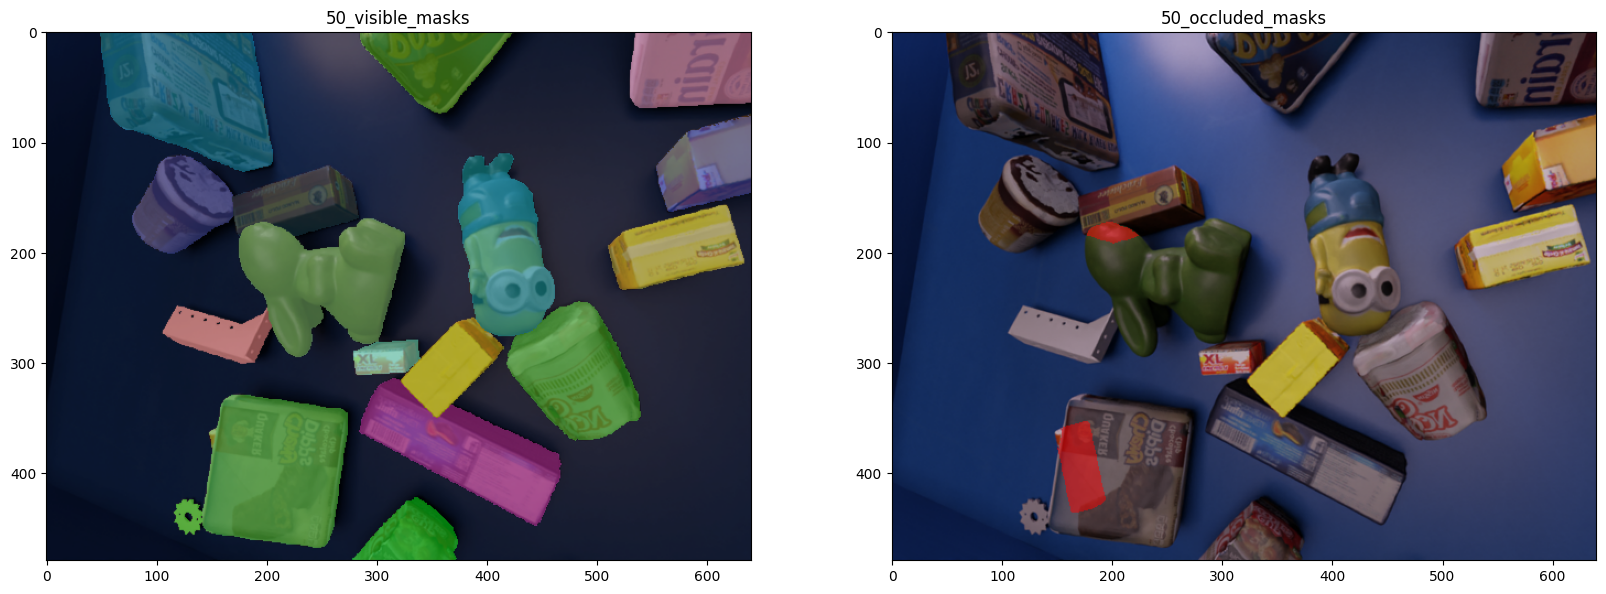

In [51]:
print("[INFO] Visualising masks...")
import glob
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

dataset_dir = "/home/ngzhili/uoais/datasets/UOAIS-Sim/val"
occlusion_dir = f"{output_dir}/occluded_masks"
visible_dir = f"{output_dir}/visible_masks"

img_check_list = []
query_img_id = [45,50]

for image_id, file_name in unique_images.items():
  
    if image_id < query_img_id[0] or (image_id % 10 != 0):
        continue
    if image_id > query_img_id[1]:
        break
    img_filename = file_name
    img_path = os.path.join(dataset_dir,img_filename)

    rgb_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB) # convert to RGB

    occ_img = rgb_img.copy()
    vis_img = rgb_img.copy()

    occ_path_list = glob.glob(f"{occlusion_dir}/{image_id}_*.png")
    vis_path_list = glob.glob(f"{visible_dir}/{image_id}_*.png")

    #cols = 4
    #rows = len(occ_path_list) //cols + 1
    
    #print(len(occ_path_list))
    #print(rows,cols)
    #fig, axes = plt.subplots(rows,cols,figsize=(15,15))
    #fig = plt.figure(figsize=(20,15))

    occ_mask_list = []
    if len(occ_path_list) > 0:
        for i in range(len(occ_path_list)):
            occ_path = occ_path_list[i]
            occluded_mask = cv2.imread(occ_path, cv2.IMREAD_UNCHANGED)
            # visualize occlusion masks on rgb
            # red = np.ones(occluded_mask.shape)
            # red = red*255
            # occ_img[:,:,0][occluded_mask>0] = red[occluded_mask>0]  

            # occ_mask_3c = np.stack((occluded_mask,)*3, -1)
            # rows, cols = np.where(occ_mask_3c[:,:,1]==255)
            # occ_mask_3c[rows,cols,:] = np.array([255, 0, 0])
            # occ_mask_list.append(occ_mask_3c)
            occ_mask_list.append(occluded_mask)
            
            #plt.subplot(len(occ_path_list))
            
            #plt.subplot(rows,cols, i+1)
            #plt.imshow(occluded_mask)
    #plt.suptitle(f"{image_id}_occluded_binary_masks")
    #plt.show()        
    
    vis_mask_list = []
    if len(vis_path_list) > 0:
        for i in range(len(vis_path_list)):
            vis_path = vis_path_list[i]
            visible_mask = cv2.imread(vis_path, cv2.IMREAD_UNCHANGED)
            # visualize occlusion masks on rgb
            visible_mask_3c = np.stack((visible_mask,)*3, -1)
            colour = np.array(list(np.random.choice(range(256), size=3)))
            rows, cols = np.where(visible_mask_3c[:,:,1]==255)
            visible_mask_3c[rows,cols,:] = colour
            vis_mask_list.append(visible_mask_3c)

    # occ combined mask
    # occ_combined_mask = np.zeros(occ_mask_3c.shape)
    # for i in occ_mask_list:
    #     occ_combined_mask += i
    # occ_combined_mask = occ_combined_mask.astype('uint8')
    occ_combined_mask = np.zeros(occluded_mask.shape)
    for i in occ_mask_list:
        occ_combined_mask += i

    occ_combined_mask = occ_combined_mask.astype(bool)
    # print(occ_combined_mask.shape)
    # print(occ_combined_mask)
    # print(np.unique(occ_combined_mask))

    alpha =0.5
    # occ_img = cv2.addWeighted(occ_combined_mask ,alpha, occ_img, 1 - alpha, 0, occ_img)
    #occ_img = cv2.addWeighted(occ_combined_mask, alpha, occ_img, 1 - alpha, 0)
    
    img_layer = occ_img.copy()
    img_layer[occ_combined_mask] = [255, 0, 0]
    occ_img = cv2.addWeighted(img_layer, alpha, occ_img, 1 - alpha, 0, occ_img)      
    
    plt.figure(figsize=(20,7))
    plt.subplot(1, 2, 2)
    plt.title(f"{image_id}_occluded_masks")
    plt.imshow(occ_img)

    # visible combined mask
    combined_mask = np.zeros(visible_mask_3c.shape)
    for i in vis_mask_list:
        combined_mask += i
    combined_mask = combined_mask.astype('uint8')
    alpha =0.5
    vis_img = cv2.addWeighted(combined_mask, alpha, vis_img, 1 - alpha,0)

    plt.subplot(1, 2, 1)
    plt.title(f"{image_id}_visible_masks")
    plt.imshow(vis_img)
    plt.show()

    #save_path = f"{output_dir}/occ_{image_id}.png"
    #cv2.imwrite(save_path,occ_img)

    #plt.imshow(vis_img)
    #plt.show()
    #plt.imshow(occ_img)
    #plt.show()

    #save_path = f"{output_dir}/vis_{image_id}.png"
    #cv2.imwrite(save_path,vis_img)

    #save_path = f"{output_dir}/overlay.png"
    #cv2.imwrite(save_path,overlay)